In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model
from sklearn.model_selection import StratifiedKFold

import model3 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss, dice_loss
from lovasz_loss import lovasz_hinge_flat, lovasz_hinge

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

In [4]:
# Settings
# ========

# Target k in KFold
CV = 2

# Skip pretraining
skip_pretraining = False

In [5]:
train_df, val_df = get_dfs_fold(k=CV)

train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True,
                                    with_aux_label=True,
                                    as_aux_label='coverage_class',
                                    use_augmentation=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
print('Loaded dataset and created loader')

Use augmentations
Loaded dataset and created loader


# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34AuxSCSE(n_classes=1, n_aux_classes=8)

if skip_pretraining:
    weight = torch.load(str(model_dir / f'unet_res34_hcauxscsev2_aug_kfold_cv{CV}_dict.model'))
    model.load_state_dict(weight, strict=False)
    print('Use pretrained weight')
    
model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())

Loaded pretrained resnet weights


In [7]:
def criterion_phase1(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = F.binary_cross_entropy_with_logits(logit.view(-1), target_pixel.view(-1), size_average=True)
    segmentation_dice_loss = dice_loss(logit, target_pixel)
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return 0.5 * segmentation_loss + 0.5 * segmentation_dice_loss + 0.05 * classification_loss

In [8]:
def train_phase1(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase1(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [9]:
if not skip_pretraining:
    model = train_phase1(model, 50, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


[2018-10-14 18:57:13.515596] Train Epoch: 0 [0/3199 (0%)]	Average loss: 0.046419
[2018-10-14 18:57:31.687492] Train Epoch: 0 [800/3199 (25%)]	Average loss: 0.035589
[2018-10-14 18:57:49.899762] Train Epoch: 0 [1600/3199 (50%)]	Average loss: 0.032935
[2018-10-14 18:58:08.109197] Train Epoch: 0 [2400/3199 (75%)]	Average loss: 0.031149
[2018-10-14 18:58:08.109197] Train Epoch: 0	IoU: 0.538077
[2018-10-14 18:58:36.312203] Train Epoch: 1 [0/3199 (0%)]	Average loss: 0.015899
[2018-10-14 18:58:54.406168] Train Epoch: 1 [800/3199 (25%)]	Average loss: 0.023699
[2018-10-14 18:59:12.585582] Train Epoch: 1 [1600/3199 (50%)]	Average loss: 0.024266
[2018-10-14 18:59:30.803092] Train Epoch: 1 [2400/3199 (75%)]	Average loss: 0.023315
[2018-10-14 18:59:30.803092] Train Epoch: 1	IoU: 0.550687
[2018-10-14 18:59:58.859251] Train Epoch: 2 [0/3199 (0%)]	Average loss: 0.034406
[2018-10-14 19:00:17.029534] Train Epoch: 2 [800/3199 (25%)]	Average loss: 0.021417
[2018-10-14 19:00:35.199212] Train Epoch: 2 [1600

[2018-10-14 19:25:41.187354] Train Epoch: 20 [2400/3199 (75%)]	Average loss: 0.009519
[2018-10-14 19:25:41.187354] Train Epoch: 20	IoU: 0.753808
[2018-10-14 19:26:09.247538] Train Epoch: 21 [0/3199 (0%)]	Average loss: 0.008843
[2018-10-14 19:26:27.387457] Train Epoch: 21 [800/3199 (25%)]	Average loss: 0.010563
[2018-10-14 19:26:45.572610] Train Epoch: 21 [1600/3199 (50%)]	Average loss: 0.010454
[2018-10-14 19:27:03.763155] Train Epoch: 21 [2400/3199 (75%)]	Average loss: 0.009842
[2018-10-14 19:27:03.763155] Train Epoch: 21	IoU: 0.746941
[2018-10-14 19:27:31.828079] Train Epoch: 22 [0/3199 (0%)]	Average loss: 0.006182
[2018-10-14 19:27:50.036817] Train Epoch: 22 [800/3199 (25%)]	Average loss: 0.008503
[2018-10-14 19:28:08.145953] Train Epoch: 22 [1600/3199 (50%)]	Average loss: 0.008977
[2018-10-14 19:28:26.328615] Train Epoch: 22 [2400/3199 (75%)]	Average loss: 0.009171
[2018-10-14 19:28:26.328615] Train Epoch: 22	IoU: 0.745318
[2018-10-14 19:28:54.407160] Train Epoch: 23 [0/3199 (0%)]	

[2018-10-14 19:54:00.159250] Train Epoch: 41 [800/3199 (25%)]	Average loss: 0.005863
[2018-10-14 19:54:18.312732] Train Epoch: 41 [1600/3199 (50%)]	Average loss: 0.005181
[2018-10-14 19:54:36.513024] Train Epoch: 41 [2400/3199 (75%)]	Average loss: 0.005350
[2018-10-14 19:54:36.513024] Train Epoch: 41	IoU: 0.782647
[2018-10-14 19:55:04.629868] Train Epoch: 42 [0/3199 (0%)]	Average loss: 0.002365
[2018-10-14 19:55:22.759304] Train Epoch: 42 [800/3199 (25%)]	Average loss: 0.005402
[2018-10-14 19:55:40.940965] Train Epoch: 42 [1600/3199 (50%)]	Average loss: 0.005713
[2018-10-14 19:55:59.153697] Train Epoch: 42 [2400/3199 (75%)]	Average loss: 0.005736
[2018-10-14 19:55:59.153697] Train Epoch: 42	IoU: 0.756804
[2018-10-14 19:56:27.238517] Train Epoch: 43 [0/3199 (0%)]	Average loss: 0.006915
[2018-10-14 19:56:45.420730] Train Epoch: 43 [800/3199 (25%)]	Average loss: 0.006343
[2018-10-14 19:57:03.609380] Train Epoch: 43 [1600/3199 (50%)]	Average loss: 0.005692
[2018-10-14 19:57:21.726334] Trai

In [10]:
save_model(model, f'unet_res34_auxscse_aug_kfold_cv{CV}_phase1')

In [11]:
def criterion_phase2(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = lovasz_hinge(logit.squeeze(), target_pixel.squeeze())
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return segmentation_loss + 0.05 * classification_loss

In [12]:
def train_phase2(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase2(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [13]:
model = train_phase2(model, 60, train_loader, val_loader)

[2018-10-14 20:06:06.394874] Train Epoch: 0 [0/3199 (0%)]	Average loss: 0.037760
[2018-10-14 20:06:26.439554] Train Epoch: 0 [800/3199 (25%)]	Average loss: 0.070139
[2018-10-14 20:06:46.547551] Train Epoch: 0 [1600/3199 (50%)]	Average loss: 0.067927
[2018-10-14 20:07:06.697347] Train Epoch: 0 [2400/3199 (75%)]	Average loss: 0.067288
[2018-10-14 20:07:06.697347] Train Epoch: 0	IoU: 0.774906
[2018-10-14 20:07:36.685841] Train Epoch: 1 [0/3199 (0%)]	Average loss: 0.045657
[2018-10-14 20:07:56.764716] Train Epoch: 1 [800/3199 (25%)]	Average loss: 0.050402
[2018-10-14 20:08:16.836424] Train Epoch: 1 [1600/3199 (50%)]	Average loss: 0.050481
[2018-10-14 20:08:36.924171] Train Epoch: 1 [2400/3199 (75%)]	Average loss: 0.050751
[2018-10-14 20:08:36.924171] Train Epoch: 1	IoU: 0.771660
[2018-10-14 20:09:06.848931] Train Epoch: 2 [0/3199 (0%)]	Average loss: 0.055375
[2018-10-14 20:09:26.913228] Train Epoch: 2 [800/3199 (25%)]	Average loss: 0.050145
[2018-10-14 20:09:47.008251] Train Epoch: 2 [1600

[2018-10-14 20:37:10.394388] Train Epoch: 20 [2400/3199 (75%)]	Average loss: 0.030636
[2018-10-14 20:37:10.394388] Train Epoch: 20	IoU: 0.801248
[2018-10-14 20:37:40.326713] Train Epoch: 21 [0/3199 (0%)]	Average loss: 0.036226
[2018-10-14 20:38:00.407310] Train Epoch: 21 [800/3199 (25%)]	Average loss: 0.031673
[2018-10-14 20:38:20.499254] Train Epoch: 21 [1600/3199 (50%)]	Average loss: 0.030807
[2018-10-14 20:38:40.562170] Train Epoch: 21 [2400/3199 (75%)]	Average loss: 0.031542
[2018-10-14 20:38:40.562170] Train Epoch: 21	IoU: 0.785893
[2018-10-14 20:39:10.547493] Train Epoch: 22 [0/3199 (0%)]	Average loss: 0.027146
[2018-10-14 20:39:30.622962] Train Epoch: 22 [800/3199 (25%)]	Average loss: 0.034086
[2018-10-14 20:39:50.670699] Train Epoch: 22 [1600/3199 (50%)]	Average loss: 0.031780
[2018-10-14 20:40:10.765976] Train Epoch: 22 [2400/3199 (75%)]	Average loss: 0.032187
[2018-10-14 20:40:10.765976] Train Epoch: 22	IoU: 0.794632
[2018-10-14 20:40:40.719479] Train Epoch: 23 [0/3199 (0%)]	

[2018-10-14 21:08:04.406117] Train Epoch: 41 [800/3199 (25%)]	Average loss: 0.026923
[2018-10-14 21:08:24.438968] Train Epoch: 41 [1600/3199 (50%)]	Average loss: 0.026516
[2018-10-14 21:08:44.499933] Train Epoch: 41 [2400/3199 (75%)]	Average loss: 0.027478
[2018-10-14 21:08:44.499933] Train Epoch: 41	IoU: 0.804494
[2018-10-14 21:09:14.500825] Train Epoch: 42 [0/3199 (0%)]	Average loss: 0.038373
[2018-10-14 21:09:34.520633] Train Epoch: 42 [800/3199 (25%)]	Average loss: 0.026115
[2018-10-14 21:09:54.571427] Train Epoch: 42 [1600/3199 (50%)]	Average loss: 0.024868
[2018-10-14 21:10:14.640613] Train Epoch: 42 [2400/3199 (75%)]	Average loss: 0.025145
[2018-10-14 21:10:14.640613] Train Epoch: 42	IoU: 0.804370
[2018-10-14 21:10:44.594132] Train Epoch: 43 [0/3199 (0%)]	Average loss: 0.019134
[2018-10-14 21:11:04.639966] Train Epoch: 43 [800/3199 (25%)]	Average loss: 0.024177
[2018-10-14 21:11:24.743064] Train Epoch: 43 [1600/3199 (50%)]	Average loss: 0.024480
[2018-10-14 21:11:44.750000] Trai

In [14]:
save_model(model, f'unet_res34_auxscse_aug_kfold_cv{CV}_phase2')

In [15]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

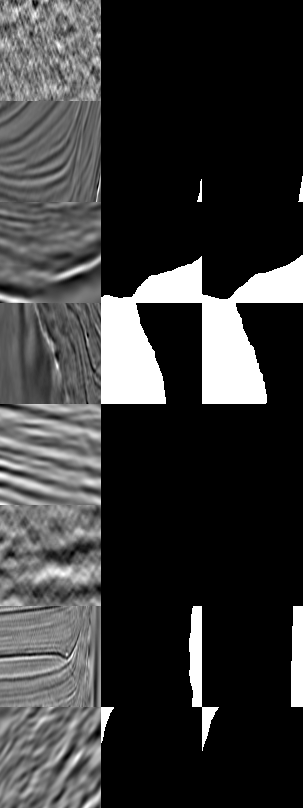

In [16]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=True, threshold=0.5)
show_prediction(im, pred, t)

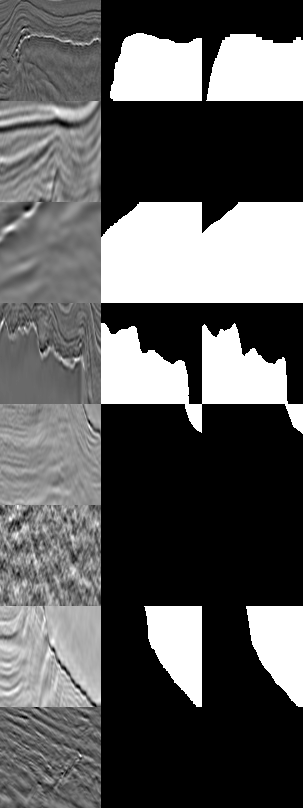

In [17]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

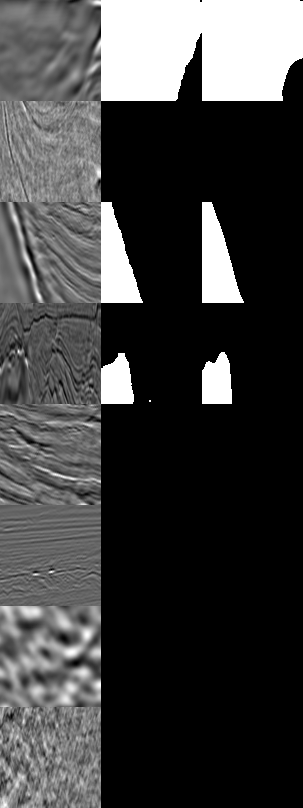

In [18]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

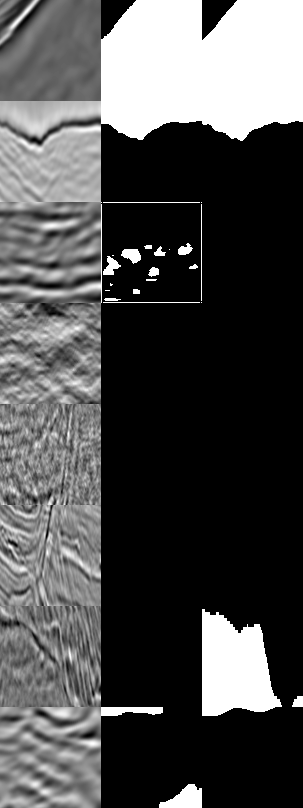

In [19]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)